In [87]:
# Import cell
import pathlib
from collections import defaultdict
import json
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


In [88]:
# if fodler trading_strat_data does not exist, create it
pathlib.Path('trading_strat_data').mkdir(parents=True, exist_ok=True)

## sanity check of the data api-dat-signal, for 10K_inofs,we indeed same 30 stocks each year for DJIA

In [89]:
# # Path to the parent directory containing year folders
# data_dir = pathlib.Path("api-data-signal/")

# year_to_companies = {}
# company_to_years = defaultdict(set)

# # Traverse each "year" folder
# for year_folder in data_dir.iterdir():
#     if year_folder.is_dir():
#         year = year_folder.name
#         companies = []
#         # Each subfolder inside 'year_folder' is treated as a ticker
#         for ticker_folder in year_folder.iterdir():
#             if ticker_folder.is_dir():
#                 companies.append(ticker_folder.name)
#                 company_to_years[ticker_folder.name].add(year)
#         year_to_companies[year] = companies

# # Build output lines
# output_lines = []
# output_lines.append("Yearly structure:")
# for year, companies in sorted(year_to_companies.items()):
#     output_lines.append(f"{year}: {len(companies)} companies")
#     output_lines.append(f"  {sorted(companies)}")

# output_lines.append("\nCompany appearances across years:")
# for company, years in sorted(company_to_years.items()):
#     output_lines.append(f"{company}: appears in {len(years)} year(s)")
#     output_lines.append(f"  {sorted(years)}")

# # Write to a file in the "trading_strat_data/" folder
# with open("trading_strat_data/summary_output.txt", "w", encoding="utf-8") as f:
#     for line in output_lines:
#         f.write(line + "\n")

# print("Summary written to summary_output.txt")


## single dataframe containing sentiment values of interest for each stock, each year

In [90]:
# Set the path to the folder containing the year folders
data_dir = pathlib.Path("api-data-signal/")

# List to hold rows for the DataFrame
rows = []

# Iterate over each year folder
for year_folder in data_dir.iterdir():
    if year_folder.is_dir():
        year = year_folder.name  # e.g., "2010", "2011", etc.
        # Iterate over each company folder within the year folder
        for company_folder in year_folder.iterdir():
            if company_folder.is_dir():
                company = company_folder.name  # e.g., "AAPL", "AMZN", etc.
                info_file = company_folder / "10_K_info.txt"
                if info_file.exists():
                    try:
                        # Read and parse the JSON content from the file
                        with open(info_file, "r", encoding="utf-8") as f:
                            content = f.read().strip()
                            # If the file is pure JSON, we can load it directly
                            info = json.loads(content)
                    except Exception as e:
                        print(f"Error reading {info_file}: {e}")
                        info = {}
                    
                    # Extract sentiment and other values
                    sentiment = info.get("sentiment_score", {})
                    row = {
                        "Year": year,
                        "Company": company,
                        "sentiment_score_positive": sentiment.get("Positive"),
                        "sentiment_score_negative": sentiment.get("Negative"),
                        "sentiment_score_polarity": sentiment.get("Polarity"),
                        "sentiment_score_subjectivity": sentiment.get("Subjectivity"),
                        "similarity_score": info.get("similarity_score"),
                        "nlp_result": info.get("nlp_result")
                    }
                    rows.append(row)
                else:
                    print(f"File not found: {info_file}")

# Create DataFrame
df = pd.DataFrame(rows)

# Optionally convert 'Year' to numeric and sort the DataFrame
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.sort_values(by=["Year", "Company"]).reset_index(drop=True)

# Display the DataFrame
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv("trading_strat_data/sentiment_analysis.csv", index=False)
print("DataFrame saved to sentiment_analysis.csv")


   Year Company  sentiment_score_positive  sentiment_score_negative  \
0  2010    AAPL                      66.0                     144.0   
1  2010    AMGN                     106.0                     106.0   
2  2010    AMZN                     110.0                      92.0   
3  2010     AXP                       1.0                       0.0   
4  2010      BA                     183.0                     379.0   

   sentiment_score_polarity  sentiment_score_subjectivity  similarity_score  \
0                 -0.371429                      0.047436          0.962567   
1                  0.000000                      0.045778          0.962118   
2                  0.089109                      0.056933          0.000000   
3                  0.999999                      0.041667          0.000000   
4                 -0.348754                      0.073889          0.982955   

   nlp_result  
0           0  
1           0  
2           0  
3           0  
4           0  
Da

In [91]:
# check the number of 0's in the dataframe df, within each column, and their percentage
zero_counts = df.isin([0]).sum()
zero_percentages = df.isin([0]).mean() * 100
print(pd.concat([zero_counts, zero_percentages], axis=1, keys=['Count', 'Percentage']))


                              Count  Percentage
Year                              0    0.000000
Company                           0    0.000000
sentiment_score_positive         32    7.619048
sentiment_score_negative         81   19.285714
sentiment_score_polarity         37    8.809524
sentiment_score_subjectivity     30    7.142857
similarity_score                  4    0.952381
nlp_result                      420  100.000000


## Retrieve market data of ADJUSTED returns (bc of stock splits, etc), and taking for year i+1, then compute returns timeframe for 1)stocks 2)DJIA as a whole

In [92]:
# Define tickers for stocks (example: 30 DJIA companies) and the DJIA ticker
tickers = [
    "AAPL", "AMGN", "AMZN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX",
    "DIS", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "NVDA", "PG", "SHW", "TRV", "UNH", "V", "VZ", "WMT"
]
djia_ticker = "^DJI"

# Define date range
start_date = "2010-01-01"
end_date = "2024-12-31"

# Download adjusted daily closing data for stocks (adjusted prices)
stocks_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"]

# Resample to yearly frequency: Get first and last prices of each year
yearly_first = stocks_data.resample("Y").first()
yearly_last = stocks_data.resample("Y").last()

# Calculate yearly returns as (last / first) - 1
yearly_returns = (yearly_last / yearly_first) - 1

# Download adjusted DJIA data and compute yearly returns similarly
djia_data = yf.download(djia_ticker, start=start_date, end=end_date, auto_adjust=True)["Close"]
djia_yearly_first = djia_data.resample("Y").first()
djia_yearly_last = djia_data.resample("Y").last()
djia_yearly_returns = (djia_yearly_last / djia_yearly_first) - 1

# Create DataFrames to display
print("Yearly Stock Returns:")
print(yearly_returns.head())

print("\nYearly DJIA Returns:")
print(djia_yearly_returns.head())

# Optionally, save the results to CSV files:
yearly_returns.to_csv("trading_strat_data/yearly_stock_returns.csv")
djia_yearly_returns.to_csv("trading_strat_data/yearly_djia_returns.csv")


[*********************100%***********************]  30 of 30 completed
/var/folders/cz/tndvsnfj5pbc0hg4zwfqf21c0000gn/T/ipykernel_32601/3509722936.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_first = stocks_data.resample("Y").first()
/var/folders/cz/tndvsnfj5pbc0hg4zwfqf21c0000gn/T/ipykernel_32601/3509722936.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_last = stocks_data.resample("Y").last()
[*********************100%***********************]  1 of 1 completed

Yearly Stock Returns:
Ticker          AAPL      AMGN      AMZN       AXP        BA       CAT  \
Date                                                                     
2010-12-31  0.507219 -0.048856  0.344287  0.067830  0.190656  0.640397   
2011-12-31  0.228874  0.167907 -0.060363  0.104228  0.131701 -0.019657   
2012-12-31  0.305586  0.370443  0.401274  0.204688  0.039844 -0.020586   
2013-12-31  0.047509  0.303361  0.549843  0.558365  0.806242 -0.008824   
2014-12-31  0.426284  0.402192 -0.220167  0.051461 -0.026749  0.045588   

Ticker           CRM      CSCO       CVX       DIS  ...      MSFT       NKE  \
Date                                                ...                       
2010-12-31  0.764234 -0.180640  0.197271  0.182422  ... -0.079441  0.326869   
2011-12-31 -0.257248 -0.107641  0.193773  0.008190  ... -0.047546  0.135908   
2012-12-31  0.661067  0.079512  0.012824  0.319618  ...  0.025976  0.081710   
2013-12-31  0.289712  0.127668  0.168769  0.513566  ...  0.39543


/var/folders/cz/tndvsnfj5pbc0hg4zwfqf21c0000gn/T/ipykernel_32601/3509722936.py:25: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  djia_yearly_first = djia_data.resample("Y").first()
/var/folders/cz/tndvsnfj5pbc0hg4zwfqf21c0000gn/T/ipykernel_32601/3509722936.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  djia_yearly_last = djia_data.resample("Y").last()


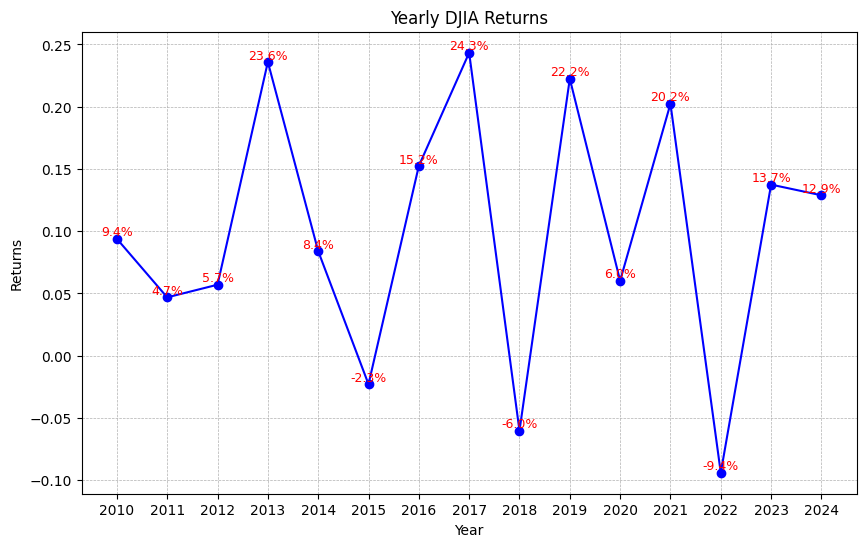

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file and convert 'Date' to year only
df = pd.read_csv("trading_strat_data/yearly_djia_returns.csv")
df['Year'] = pd.to_datetime(df['Date']).dt.year

plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['^DJI'], marker='o', linestyle='-', color='b')

plt.title('Yearly DJIA Returns')
plt.xlabel('Year')
plt.ylabel('Returns')

# Set x-ticks to show every year
plt.xticks(df['Year'])

# Enable grid for both major and minor ticks (vertical grid line per x-tick)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate each data point with its return value formatted as a percentage.
# Multiply each value by 100 for percentage formatting.
for x, y in zip(df['Year'], df['^DJI']):
    plt.text(x, y, f'{y * 100:.1f}%', ha='center', va='bottom', fontsize=9, color='red')

plt.show()


# Project Data Overview

This project has generated three key datasets that serve as the foundation for further analysis:

1. **Yearly Returns for Each DJIA Stock**
   - **Description:**  
     A DataFrame where each row represents a year and each column represents one of the 30 DJIA stocks.
   - **Calculation:**  
     Yearly return is calculated using the formula:  
     \[
     \text{Return} = \left(\frac{\text{Last Adjusted Price}}{\text{First Adjusted Price}}\right) - 1
     \]
   - **Purpose:**  
     Provides an overview of the annual performance of each stock.

2. **Yearly Returns for the DJIA Index**
   - **Description:**  
     A separate DataFrame showing the yearly return for the DJIA index as a whole (using the `^DJI` ticker).
   - **Calculation:**  
     Calculated using the same method as the individual stocks.
   - **Purpose:**  
     Offers a benchmark for the overall market performance.

3. **Sentiment Analysis DataFrame**
   - **Description:**  
     A DataFrame that contains sentiment analysis metrics for each company (ticker) for each year.
   - **Metrics Included:**  
     - `sentiment_score_positive`: Number of positive sentiment counts.
     - `sentiment_score_negative`: Number of negative sentiment counts.
     - `sentiment_score_polarity`: Overall polarity of the sentiment.
     - `sentiment_score_subjectivity`: How subjective the sentiment is.
     - `similarity_score`: Similarity metric from NLP analysis.
     - `nlp_result`: Additional NLP-derived result.
   - **Purpose:**  
     Enables analysis of textual sentiment in relation to each company’s performance and trends over the years.


## Merge all dataset logically

In [98]:
# --- 1. Load the Sentiment Analysis CSV ---
df_sentiment = pd.read_csv("trading_strat_data/sentiment_analysis.csv")
# Convert Year to numeric and shift by 1 so that sentiment for year i becomes year i+1
df_sentiment["Year"] = pd.to_numeric(df_sentiment["Year"], errors="coerce") + 1

# --- 2. Load and Process the Yearly Stock Returns CSV ---
df_stocks = pd.read_csv("trading_strat_data/yearly_stock_returns.csv", parse_dates=True)
if "Year" not in df_stocks.columns:
    if "Date" in df_stocks.columns:
        df_stocks["Year"] = pd.to_datetime(df_stocks["Date"]).dt.year
    else:
        df_stocks = df_stocks.reset_index()
        if "index" in df_stocks.columns:
            df_stocks = df_stocks.rename(columns={"index": "Date"})
        df_stocks["Year"] = pd.to_datetime(df_stocks["Date"]).dt.year
df_stocks_long = pd.melt(df_stocks, id_vars=["Year"], var_name="Company", value_name="Yearly_Return")

# --- 3. Load and Process the Yearly DJIA Returns CSV ---
df_djia = pd.read_csv("trading_strat_data/yearly_djia_returns.csv", parse_dates=True)
if "Year" not in df_djia.columns:
    if "Date" in df_djia.columns:
        df_djia["Year"] = pd.to_datetime(df_djia["Date"]).dt.year
    else:
        df_djia = df_djia.reset_index()
        if "index" in df_djia.columns:
            df_djia = df_djia.rename(columns={"index": "Date"})
        df_djia["Year"] = pd.to_datetime(df_djia["Date"]).dt.year
djia_return_col = [col for col in df_djia.columns if col not in ["Year", "Date"]][0]
df_djia = df_djia.rename(columns={djia_return_col: "DJIA_Return_Previous_Year"})
df_djia["Year"] = df_djia["Year"] + 1  # Shift the DJIA year so that, e.g., the 2010 value is used for 2011

# --- 4. Merge the DataFrames ---
df_merge = pd.merge(df_sentiment, df_stocks_long, on=["Year", "Company"], how="inner")
df_final = pd.merge(df_merge, df_djia[["Year", "DJIA_Return_Previous_Year"]], on="Year", how="left")

# --- 5. Output ---
print(df_final.head())
df_final.to_csv("trading_strat_data/merged_data.csv", index=False)
print("Merged data saved to trading_strat_data/merged_data.csv")


   Year Company  sentiment_score_positive  sentiment_score_negative  \
0  2011    AAPL                      66.0                     144.0   
1  2011    AMGN                     106.0                     106.0   
2  2011    AMZN                     110.0                      92.0   
3  2011     AXP                       1.0                       0.0   
4  2011      BA                     183.0                     379.0   

   sentiment_score_polarity  sentiment_score_subjectivity  similarity_score  \
0                 -0.371429                      0.047436          0.962567   
1                  0.000000                      0.045778          0.962118   
2                  0.089109                      0.056933          0.000000   
3                  0.999999                      0.041667          0.000000   
4                 -0.348754                      0.073889          0.982955   

   nlp_result Yearly_Return  DJIA_Return_Previous_Year  
0           0      0.228874              

In [99]:
sector_mapping = {
    "AAPL": "Information Technology",
    "AMGN": "Health Care",
    "AMZN": "Consumer Discretionary",
    "AXP": "Financials",
    "BA": "Industrials",
    "CAT": "Industrials",
    "CRM": "Information Technology",
    "CSCO": "Information Technology",
    "CVX": "Energy",
    "DIS": "Communication Services",
    "GS": "Financials",
    "HD": "Consumer Discretionary",
    "HON": "Industrials",
    "IBM": "Information Technology",
    "JNJ": "Health Care",
    "JPM": "Financials",
    "KO": "Consumer Staples",
    "MCD": "Consumer Discretionary",
    "MMM": "Industrials",
    "MRK": "Health Care",
    "MSFT": "Information Technology",
    "NKE": "Consumer Discretionary",
    "NVDA": "Information Technology",
    "PG": "Consumer Staples",
    "SHW": "Materials",
    "TRV": "Financials",
    "UNH": "Health Care",
    "V": "Financials",
    "VZ": "Communication Services",
    "WMT": "Consumer Staples"
}


# add a new column 'Sector' to the DataFrame df_final
df_final["Sector"] = df_final["Company"].map(sector_mapping)


In [100]:
# save it back to merged_data.csv
df_final.to_csv("trading_strat_data/merged_data.csv", index=False)
print("Merged data with sector saved to trading_strat_data/merged_data.csv")

Merged data with sector saved to trading_strat_data/merged_data.csv
